# 1 - Imports + Preparation 

In [1]:
import torch
import numpy as np
import spyrit.misc.walsh_hadamard as wh

from matplotlib import pyplot as plt
from pathlib import Path

from spyrit.learning.model_Had_DCAN_1 import *
from spyrit.misc.disp import torch2numpy, imagesc, plot
# from spyrit.misc.statistics import Cov2Var
# from spyrit.learning.model_Had_DCAN import Cov2Var
from spyrit.learning.nets import *
from spyrit.misc.metrics import psnr_

# from spas import read_metadata, reconstruction_hadamard
# from spas import ReconstructionParameters, setup_reconstruction, load_noise, reconstruct
# from spas.noise import noiseClass
# from spas.visualization import *
#from siemens_star_analysis import *



In [2]:
plt.rcParams['text.usetex'] = True

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Torch device: {device}')



Torch device: cpu


In [3]:
#%% Spectral binning (and checking a few things)
def subsample(spectral_data, CR):
    # If only one wavelength is considered
    if spectral_data.ndim == 1:
        torch_img = np.zeros((2*CR))
        
        pos = spectral_data[0::2][:CR]
        neg = spectral_data[1::2][:CR]
        
        torch_img[0::2] = pos
        torch_img[1::2] = neg
    
    # If spectral_data contains  all wavelengths
    if spectral_data.ndim == 2:
        
        torch_img = np.zeros((2*CR, spectral_data.shape[1]))
        
        pos = spectral_data[0::2][:CR,:]
        neg = spectral_data[1::2][:CR,:]
        
        torch_img[0::2,:] = pos
        torch_img[1::2,:] = neg
    
    return torch_img


def meas2img_from_ind(meas, ind, N):
    """Return image from measurement vector

    Args:
        meas (ndarray): Measurement vector. Must be 1-D.
        ind (ndarray):  Pattern indices. Must be 1-D.
        N (int):        Returned image will be N x N

    Returns:
        Img (ndarray): Measurement image. 2-D array
    """
    y = np.pad(meas, (0, N**2-len(meas)))
    Perm = permutation_from_ind(ind+1)
    Img = (Perm @ y).reshape((N, N))
    return Img

def completion(meas, M, Perm, Cov, Mean):
    
    nx, ny = Mean.shape
    
    # reorder measurements and statistics
    y     = Perm @ (meas.ravel())
    mu    = Perm @ (Mean.ravel())
    Sigma = Perm @ Cov @ Perm.T
    
    # extract blocks corresponding to acquired and missing measurements 
    mu1 = mu[:M]            # mean of acquired measurements
    mu2 = mu[M:]            # mean of missing measurements
    Sigma1  = Sigma[:M,:M]  # covariance of acquired measurements
    Sigma21 = Sigma[M:,:M]  # covariance of missing measurements

    m = y[:M];
    
    # Bayesian denoised completion
    #y1 = mu1 + W1 @ ( m - mu1)
    y1 = m
    #y2 = mu2 + Sigma21 @ np.linalg.lstsq(Sigma1,(y1 - mu1), rcond=None)[0]
    y2 = Sigma21 @ np.linalg.lstsq(Sigma1, y1, rcond=None)[0]
    #y2 = Sigma21 @ np.linalg.inv(Sigma1) @ y1
    y[:M] = y1
    y[M:] = y2
    
    # reorder output
    y = Perm.T @ y
    y = np.reshape(y,(nx, ny))
    
    return y

def unsplit(raw):
    had = raw[0::2] - raw[1::2]
    return had

# 2 - Parameters and Neural Network

In [4]:
#%% Load reconstrcution network
img_size = 64

# --network architecture --> ['c0mp', 'comp','pinv', 'free'] --> [0, 1, 2, 3]
net_type = ['NET_c0mp', 'NET_comp', 'NET_pinv', 'NET_free']
net_arch = 0 # Network variant
CR = 2048;


# Intensity distribution
N0 = 10
sig = 0.0
NVMS = np.diag((img_size ** 2) * np.ones(CR)) / N0

In [5]:
model_root = Path('/media/licho/0A286AF6286AE065/Users/Luis/Documents/Deep Learning/training_models-main/')
H = wh.walsh2_matrix(img_size) / img_size
Mean = np.load('/media/licho/0A286AF6286AE065/Users/Luis/Documents/Deep Learning/Test/Stats_Walsh/Average_64x64.npy')/img_size
Cov  = np.load('/media/licho/0A286AF6286AE065/Users/Luis/Documents/Deep Learning/Test/Stats_Walsh/Cov_64x64.npy')/img_size**2

In [6]:
Var = Cov2Var(Cov);
Perm = Permutation_Matrix(Var);
H_k = img_size*np.dot(Perm,H);
Pmat = H_k[:CR,:];

In [7]:
#- Training parameters
num_epochs = 30
lr = 1e-3 
step_size = 10
gamma = 0.5
batch_size = 256
reg = 1e-7
Niter = 1


# -- Loading MMSE models

In [8]:
# List of models
models = []

### model 1 : Denoising stage with diagonal matrix approximation (k=0)

In [9]:
models.append(DenoiCompNet_NVMS(img_size, CR, Mean, Cov, NVMS, Niter = Niter, variant = net_arch,
                                        denoi=1, N0=N0, sig=sig, H=H, Ord=Var))

models[0].to(device)

# -- Load net
suffix1 = '_N0_{}_sig_{}_Denoi_Diag_Niter_{}_N_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format( \
                N0, sig, Niter, img_size, CR, num_epochs, lr, step_size, gamma, batch_size, reg)

title1 = model_root / (net_type[net_arch] + suffix1)
load_net(title1, models[0], device)

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Iterative Neural Network with denoised measurements (by diagonal approximation ). For 1 iterations
Model Loaded: /media/licho/0A286AF6286AE065/Users/Luis/Documents/Deep Learning/training_models-main/NET_c0mp_N0_10_sig_0.0_Denoi_Diag_Niter_1_N_64_M_2048_epo_30_lr_0.001_sss_10_sdr_0.5_bs_256_reg_1e-07


### model 2 : Denoising stage with a first order taylor approximation + NVMS (with max matrix) and k=0. 

In [10]:
models.append(DenoiCompNet_NVMS(img_size, CR, Mean, Cov, NVMS, Niter=Niter,
                                                variant=net_arch, denoi=0, N0=N0, sig=sig, H=H, Ord=Var))
models[1].to(device)

# -- Load net
suffix2 = '_N0_{}_sig_{}_Denoi_NVMS_Niter_{}_N_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format( \
        N0, sig, Niter, img_size, CR, num_epochs, lr, step_size, gamma, batch_size, reg)

title2 = model_root / (net_type[net_arch] + suffix2)
load_net(title2, models[1], device)

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Iterative Neural Network with denoised measurements (by NVMS approximation ). For 1 iterations
Model Loaded: /media/licho/0A286AF6286AE065/Users/Luis/Documents/Deep Learning/training_models-main/NET_c0mp_N0_10_sig_0.0_Denoi_NVMS_Niter_1_N_64_M_2048_epo_30_lr_0.001_sss_10_sdr_0.5_bs_256_reg_1e-07


### model 3 : Denoising stage with full matrix inversion -- vanilla version (k=0)

In [11]:
models.append(DenoiCompNet_NVMS(img_size, CR, Mean, Cov, NVMS, Niter=Niter, variant=net_arch, denoi=2,
                                         N0=N0, sig=sig, H=H, Ord=Var))
models[2].to(device)

# -- Load net
suffix3 = '_N0_{}_sig_{}_Denoi_Full_Niter_{}_N_{}_M_{}_epo_{}_lr_{}_sss_{}_sdr_{}_bs_{}_reg_{}'.format( \
        N0, sig, Niter, img_size, CR, num_epochs, lr, step_size, gamma, batch_size, reg)

title3 = model_root / (net_type[net_arch] + suffix3)
# load_net(title3, models[2], device)

Measurement to image domain: statistical completion (no mean)
Varying N0 = 10 +/- 0
Iterative Neural Network with denoised measurements (by full inverse product). For 1 iterations


# 3 - Experimental Horse

### 3.1 - Loading data and visualising

In [143]:
# f = np.load('./data/tomato_slice/tomato_slice_2_zoomx12_had_reco.npz')
# raw = np.load('./data/tomato_slice/tomato_slice_2_zoomx12_spectraldata.npz')

f = np.load('/home/licho/Documentos/MAS/Stage_Master/Article/Resources/Horse_WhiteLamp_had_reco.npz')
raw = np.load('/home/licho/Documentos/MAS/Stage_Master/Article/Resources/Horse_WhiteLamp_spectraldata.npz')

# for key in f:
#     print(key)

# for key in raw:
#     print(key)    

spectral_data = f['arr_0']
raw_data = raw['spectral_data']

# metadata, acquisition_metadata, spectrometer_parameters, dmd_parameters = read_metadata('./data/zoom_x1_starsector/zoom_x1_metadata.json')
# wavelengths = np.asarray(acquisition_metadata.wavelengths)
# print(f'Spectral data dimensions: {spectral_data.shape}')
# print(f'Wavelength range: {wavelengths[0]} - {wavelengths[-1]} nm')
# print('\nAcquired data description:')
# print(f'Light source: {metadata.light_source}')
# print(f'Object: {metadata.object}')
# print(f'Filter: {metadata.filter}')
# print(f'Patterns: {acquisition_metadata.pattern_amount}')
# print(f'Integration time: {spectrometer_parameters.integration_time_ms} ms')
# print(metadata)



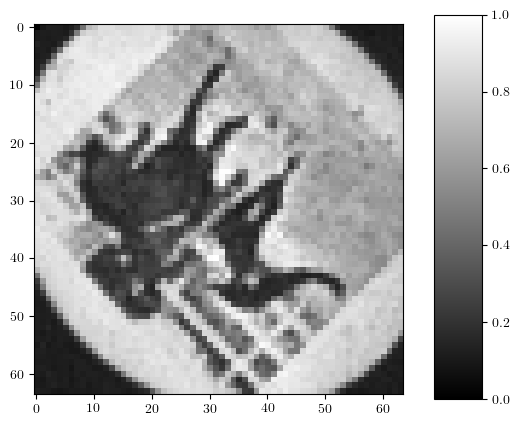

In [144]:
img_GT_all_Channels = np.sum(raw_data, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

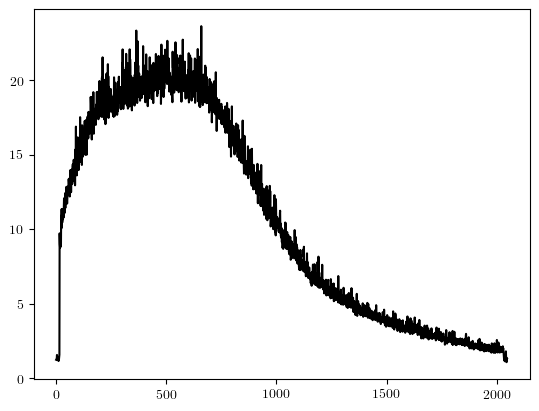

In [145]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

In [146]:
index = 715;
F_bin_GT = spectral_data[:,:,index];
raw_data = raw_data[:,index];
# imagesc(F_bin_GT)
img_size = F_bin_GT.shape[0]

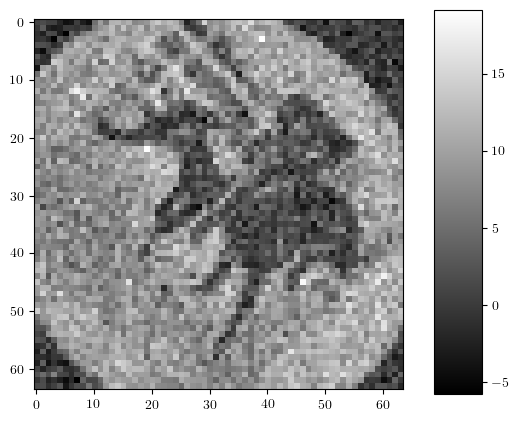

In [147]:
imagesc(F_bin_GT)

In [148]:
m_raw_data = raw_data[:2*CR];

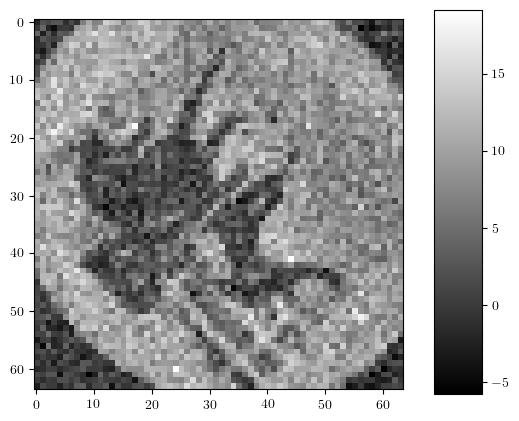

In [149]:
raw_unsplit = raw_data[0::2] - raw_data[1::2];
pinv_test = np.dot(np.transpose(H_k), raw_unsplit);
pinv_test = (1/img_size**2)*np.reshape(pinv_test, (img_size, img_size))
imagesc(pinv_test)

### 3.2 - Pinv reconstruction

In [150]:
m = torch.Tensor(m_raw_data);
m = m.view(1,1,2*CR).to(device);

psnr = 23.599631995043357


16.317383

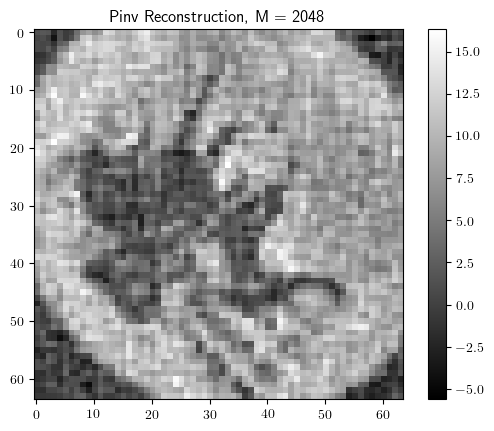

In [151]:
#%% PINV recon
x_inv = models[0].forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
x_inv = (x_inv+1)*models[2].N0/2
recon_pinv = torch2numpy(x_inv.view(img_size,img_size))

plt.figure()
plt.title(f"Pinv Reconstruction, M = {CR}")
plt.imshow(recon_pinv, cmap='gray')
plt.colorbar()

img_temp = recon_pinv;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))
recon_pinv.max()

### 3.3 - MMSE results

In [158]:
# MMSE results
f=[]
img_temp=[]

for i in range(3): # Load analytical layers
    
    models[i].N0 = recon_pinv.max() # setting the maximum light intensity
    
    if i==1:
        shrink = 1.4
        NVMS_pinv = np.diag((img_size ** 2) * np.ones(CR)) / (shrink * models[i].N0) # Tuning of the Taylor matrix weights

        P0, P1, P2 = models[i].forward_denoise_operators(Cov, NVMS_pinv, img_size, CR)
        models[i].fcP0 = P0 
        models[i].fcP1 = P1
        models[i].fcP2 = P2
    
    temp = models[i].forward_reconstruct_mmse(m, 1, 1, img_size, img_size)
    temp = (temp + 1) *  models[i].N0 / 2       
    temp = temp.cpu().detach().numpy().squeeze() 
    f.append(temp)
         
    img_temp.append(f[i])
    img_temp[i] =  (img_temp[i] - np.amin(img_temp[i]))/(np.amax(img_temp[i])-np.amin(img_temp[i]))
    
for i in range(2): # Load CNN layers
    temp = models[i].forward_reconstruct(m, 1, 1, img_size, img_size)
    temp = (temp + 1) * models[0].N0 / 2         
    temp = temp.cpu().detach().numpy().squeeze() 
    f.append(temp)
         
    img_temp.append(f[i+3])
    img_temp[i+3] =  (img_temp[i+3] - np.amin(img_temp[i+3]))/(np.amax(img_temp[i+3])-np.amin(img_temp[i+3]))

MMSE recon, N0 est = 16.3ph (from GT), M = 2048, Net = 10ph, Lambda = 715
Diagonal approximation
psnr = 24.79
Proposed approximation
psnr = 25.39
Exact solution
psnr = 25.74
Diagonal approx + CNN
psnr = 26.08
Proposed approx + CNN
psnr = 21.90


<function matplotlib.pyplot.show(close=None, block=None)>

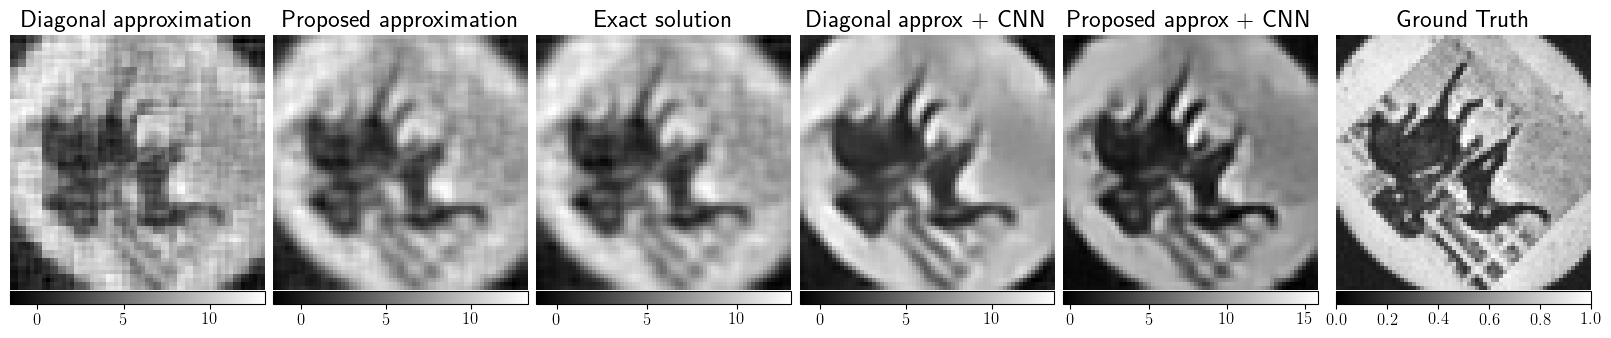

In [159]:
titles = ['Diagonal approximation', 'Proposed approximation', 'Exact solution', 'Diagonal approx + CNN', 'Proposed approx + CNN', 'Ground Truth'] 

print(f'MMSE recon, N0 est = {models[0].N0:.1f}ph (from GT), M = {CR}, Net = {N0}ph, Lambda = {index}')
for i in range(5):
    print (titles[i])
    print("psnr = %.2f" % psnr_(img_GT_all_Channels,img_temp[i]))


fig, axs = plt.subplots(1, 6, figsize=(16, 16), constrained_layout=True)

for i in range(5):
    im = axs[i].imshow(f[i], cmap='gray')
    axs[i].set_title(titles[i], fontsize = 18)
    cbar= plt.colorbar(im, ax=axs[i], shrink=1, orientation = 'horizontal', pad = 0.0)
    cbar.ax.tick_params(labelsize=12)
    axs[i].axis('off')
    
im = axs[5].imshow(img_GT_all_Channels, cmap='gray')
axs[5].set_title(titles[5], fontsize = 18)
cbar=plt.colorbar(im, ax=axs[5], shrink=1, orientation = 'horizontal', pad = 0.0)
cbar.ax.tick_params(labelsize=12)
plt.axis('off')
plt.show

# 4 - Experimental Cat

### 4.1 - Loading data and visualising

In [24]:
# f = np.load('./data/tomato_slice/tomato_slice_2_zoomx12_had_reco.npz')
# raw = np.load('./data/tomato_slice/tomato_slice_2_zoomx12_spectraldata.npz')

f = np.load('/home/licho/Documentos/MAS/Stage_Master/Article/Resources/Cat_whiteLamp_had_reco.npz')
raw = np.load('/home/licho/Documentos/MAS/Stage_Master/Article/Resources/Cat_whiteLamp_spectraldata.npz')

# for key in f:
#     print(key)

# for key in raw:
#     print(key)    

spectral_data = f['arr_0']
raw_data = raw['spectral_data']

# metadata, acquisition_metadata, spectrometer_parameters, dmd_parameters = read_metadata('./data/zoom_x1_starsector/zoom_x1_metadata.json')
# wavelengths = np.asarray(acquisition_metadata.wavelengths)
# print(f'Spectral data dimensions: {spectral_data.shape}')
# print(f'Wavelength range: {wavelengths[0]} - {wavelengths[-1]} nm')
# print('\nAcquired data description:')
# print(f'Light source: {metadata.light_source}')
# print(f'Object: {metadata.object}')
# print(f'Filter: {metadata.filter}')
# print(f'Patterns: {acquisition_metadata.pattern_amount}')
# print(f'Integration time: {spectrometer_parameters.integration_time_ms} ms')
# print(metadata)

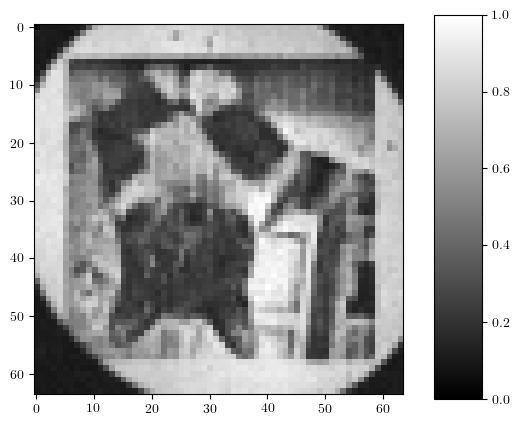

In [25]:
img_GT_all_Channels = np.sum(raw_data, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

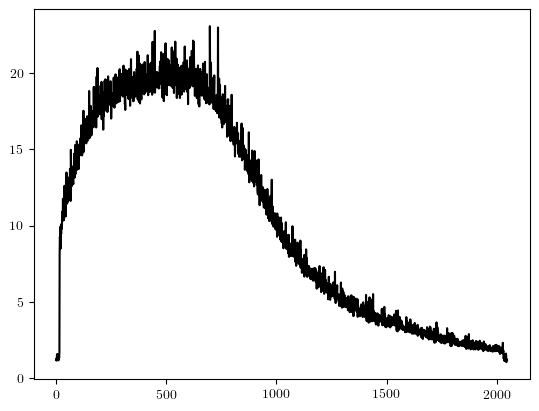

In [26]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

In [27]:
index = 1198;
F_bin_GT = spectral_data[:,:,index];
raw_data = raw_data[:,index];
# imagesc(F_bin_GT)
img_size = F_bin_GT.shape[0]

In [28]:
m_raw_data = raw_data[:2*CR];

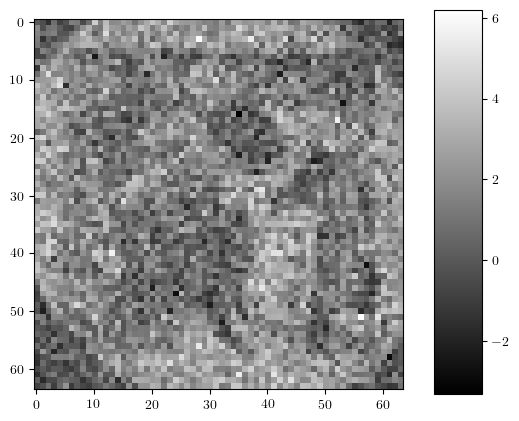

In [29]:
raw_unsplit = raw_data[0::2] - raw_data[1::2];
pinv_test = np.dot(np.transpose(H_k), raw_unsplit);
pinv_test = (1/img_size**2)*np.reshape(pinv_test, (img_size, img_size))
imagesc(pinv_test)

### 4.2 - Pinv reconstruction

In [30]:
m = torch.Tensor(m_raw_data);
m = m.view(1,1,2*CR).to(device);

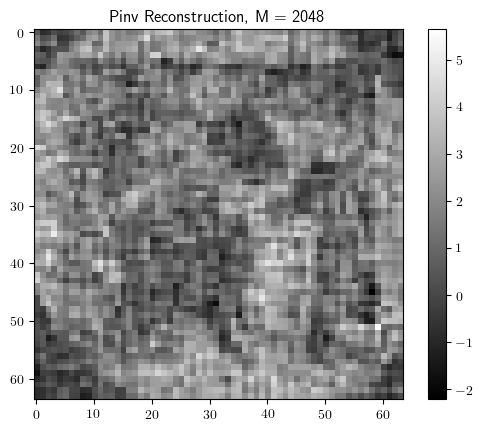

In [31]:
#%% PINV recon
x_inv = models[0].forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
x_inv = (x_inv+1)*models[0].N0/2
recon_pinv = torch2numpy(x_inv.view(img_size,img_size))

plt.figure()
plt.title(f"Pinv Reconstruction, M = {CR}")
plt.imshow(recon_pinv, cmap='gray')
plt.colorbar()

img_temp = recon_pinv;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))

## 4.3 - MMSE results

In [32]:
# MMSE results
f=[]
img_temp=[]

for i in range(3): # Load analytical layers
    
    models[i].N0 = recon_pinv.max() # setting the maximum light intensity
    
    if i==1:
        NVMS_pinv = np.diag((img_size ** 2) * np.ones(CR)) / N0 # recon_pinv.max() # Tuning of the Taylor matrix weights

        P0, P1, P2 = models[i].forward_denoise_operators(Cov, NVMS_pinv, img_size, CR)
        models[i].fcP0 = P0 
        models[i].fcP1 = P1
        models[i].fcP2 = P2
    
    temp = models[i].forward_reconstruct_mmse(m, 1, 1, img_size, img_size)
    temp = (temp + 1) * models[0].N0/2;         
    temp = temp.cpu().detach().numpy().squeeze() 
    f.append(temp)
         
    img_temp.append(f[i])
    img_temp[i] =  (img_temp[i] - np.amin(img_temp[i]))/(np.amax(img_temp[i])-np.amin(img_temp[i]))
    
for i in range(2): # Load CNN layers
    temp = models[i].forward_reconstruct(m, 1, 1, img_size, img_size)
    temp = (temp + 1) * models[0].N0/2;         
    temp = temp.cpu().detach().numpy().squeeze() 
    f.append(temp)
         
    img_temp.append(f[i+3])
    img_temp[i+3] =  (img_temp[i+3] - np.amin(img_temp[i+3]))/(np.amax(img_temp[i+3])-np.amin(img_temp[i+3]))

MMSE recon, N0 est = 5.6ph (from GT), M = 2048, Net = 10ph, Lambda = 1198
Diagonal approximation
psnr = 22.95
Proposed approximation
psnr = 23.96
Exact solution
psnr = 24.20
Diagonal approx + CNN
psnr = 24.16
Proposed approx + CNN
psnr = 24.52


<function matplotlib.pyplot.show(close=None, block=None)>

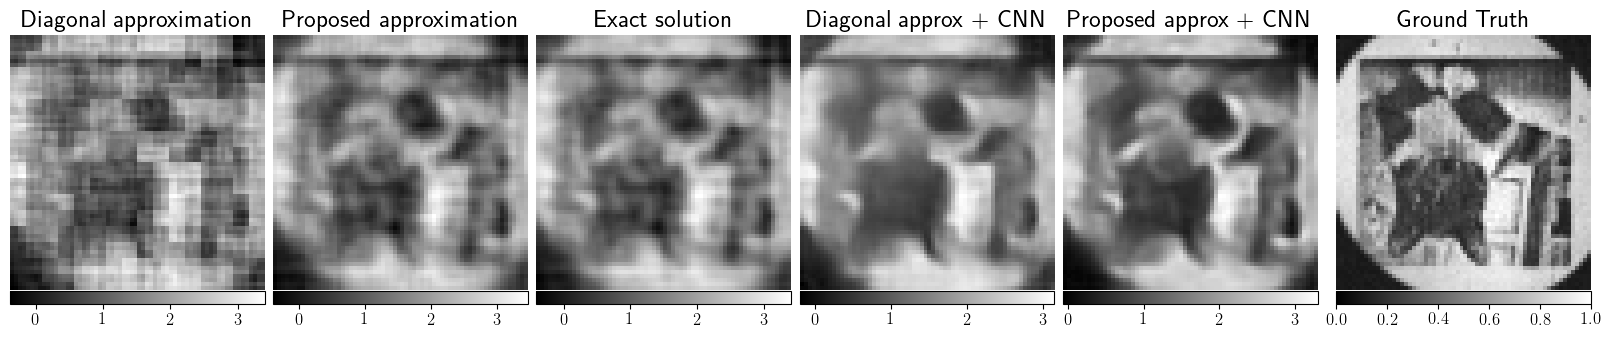

In [33]:
titles = ['Diagonal approximation', 'Proposed approximation', 'Exact solution', 'Diagonal approx + CNN', 'Proposed approx + CNN', 'Ground Truth'] 

print(f'MMSE recon, N0 est = {models[0].N0:.1f}ph (from GT), M = {CR}, Net = {N0}ph, Lambda = {index}')
for i in range(5):
    print (titles[i])
    print("psnr = %.2f" % psnr_(img_GT_all_Channels,img_temp[i]))

fig, axs = plt.subplots(1, 6, figsize=(16, 16), constrained_layout=True)

for i in range(5):
    im = axs[i].imshow(f[i], cmap='gray')
    axs[i].set_title(titles[i], fontsize = 18)
    cbar= plt.colorbar(im, ax=axs[i], shrink=1, orientation = 'horizontal', pad = 0.0)
    cbar.ax.tick_params(labelsize=12)
    axs[i].axis('off')
    
im = axs[5].imshow(img_GT_all_Channels, cmap='gray')
axs[5].set_title(titles[5], fontsize = 18)
cbar=plt.colorbar(im, ax=axs[5], shrink=1, orientation = 'horizontal', pad = 0.0)
cbar.ax.tick_params(labelsize=12)
plt.axis('off')
plt.show

# 5 - Experimental Star Sector

### 5.1 - Loading data and visualising

In [34]:
f = np.load('/home/licho/Documentos/MAS/Stage_Master/Article/Resources/zoom_x1_had_reco.npz')
raw = np.load('/home/licho/Documentos/MAS/Stage_Master/Article/Resources/zoom_x1_spectraldata.npz')

# for key in f:
#     print(key)

# for key in raw:
#     print(key)    

spectral_data = f['arr_0']
raw_data = raw['spectral_data']

# metadata, acquisition_metadata, spectrometer_parameters, dmd_parameters = read_metadata('./data/zoom_x1_starsector/zoom_x1_metadata.json')
# wavelengths = np.asarray(acquisition_metadata.wavelengths)
# print(f'Spectral data dimensions: {spectral_data.shape}')
# print(f'Wavelength range: {wavelengths[0]} - {wavelengths[-1]} nm')
# print('\nAcquired data description:')
# print(f'Light source: {metadata.light_source}')
# print(f'Object: {metadata.object}')
# print(f'Filter: {metadata.filter}')
# print(f'Patterns: {acquisition_metadata.pattern_amount}')
# print(f'Integration time: {spectrometer_parameters.integration_time_ms} ms')
# print(metadata)

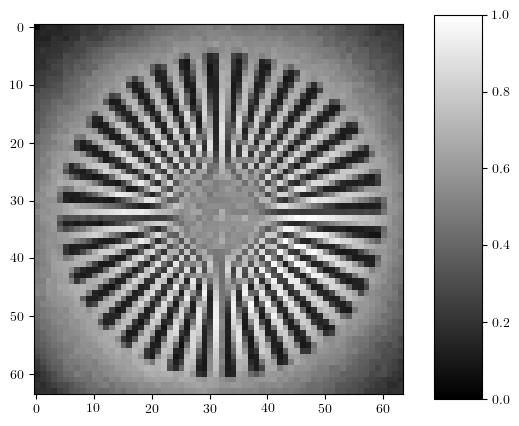

In [35]:
img_GT_all_Channels = np.sum(raw_data, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

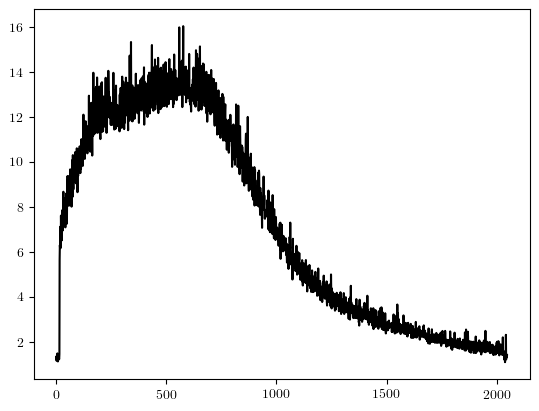

In [36]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

In [37]:
index = 300;
F_bin_GT = spectral_data[:,:,index];
raw_data = raw_data[:,index];
# imagesc(F_bin_GT)
img_size = F_bin_GT.shape[0]

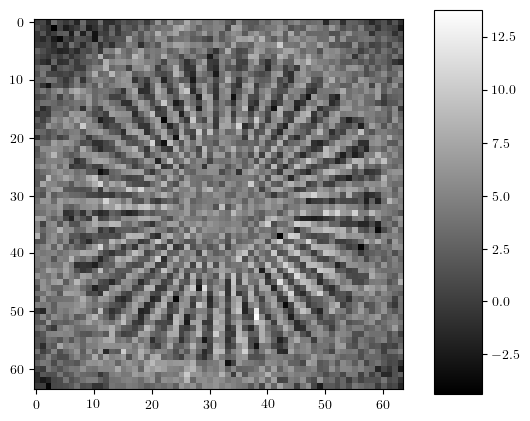

In [38]:
imagesc(F_bin_GT)

In [39]:
m_raw_data = raw_data[:2*CR];

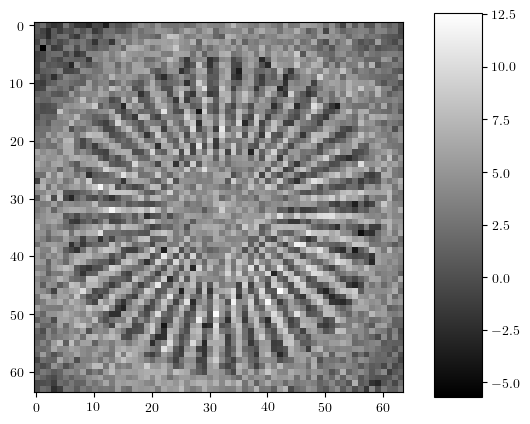

psnr = 23.3837514086353


In [40]:
# WHY NOT THE SAME!? - Bref, pas important, surement lié aux meta données... [les indices ne doivent pas être dans l'ordre des longeurs d'onde] + Image Flippée
raw_unsplit = raw_data[0::2] - raw_data[1::2];
pinv_test = np.dot(np.transpose(H_k), raw_unsplit);
pinv_test = (1/img_size**2)*np.reshape(pinv_test, (img_size, img_size))
imagesc(pinv_test)

img_temp = pinv_test;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

### 5.2 - Pinv reconstruction

In [41]:
m = torch.Tensor(m_raw_data);
m = m.view(1,1,2*CR).to(device);

psnr = 22.758558526856234


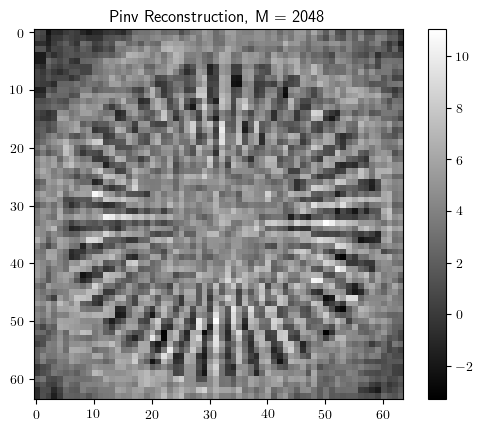

In [42]:
#%% PINV recon
x_inv = models[0].forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
x_inv = (x_inv+1)*models[0].N0/2
recon_pinv = torch2numpy(x_inv.view(img_size,img_size))

plt.figure()
plt.title(f"Pinv Reconstruction, M = {CR}")
plt.imshow(recon_pinv, cmap='gray')
plt.colorbar()

img_temp = recon_pinv;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

## 5.3 - MMSE results

In [43]:
# MMSE results
f=[]
img_temp=[]

for i in range(3): # Load analytical layers
    
    models[i].N0 = recon_pinv.max() # setting the maximum light intensity
    
    if i==1:
        NVMS_pinv = np.diag((img_size ** 2) * np.ones(CR)) / N0 # recon_pinv.max() # Tuning of the Taylor matrix weights

        P0, P1, P2 = models[i].forward_denoise_operators(Cov, NVMS_pinv, img_size, CR)
        models[i].fcP0 = P0 
        models[i].fcP1 = P1
        models[i].fcP2 = P2
    
    temp = models[i].forward_reconstruct_mmse(m, 1, 1, img_size, img_size)
    temp = (temp + 1) * models[0].N0/2;         
    temp = temp.cpu().detach().numpy().squeeze() 
    f.append(temp)
         
    img_temp.append(f[i])
    img_temp[i] =  (img_temp[i] - np.amin(img_temp[i]))/(np.amax(img_temp[i])-np.amin(img_temp[i]))
    
for i in range(2): # Load CNN layers
    temp = models[i].forward_reconstruct(m, 1, 1, img_size, img_size)
    temp = (temp + 1) * models[0].N0/2;         
    temp = temp.cpu().detach().numpy().squeeze() 
    f.append(temp)
         
    img_temp.append(f[i+3])
    img_temp[i+3] =  (img_temp[i+3] - np.amin(img_temp[i+3]))/(np.amax(img_temp[i+3])-np.amin(img_temp[i+3]))

MMSE recon, N0 est = 11.0ph (from GT), M = 2048, Net = 10ph, Lambda = 300
Diagonal approximation
psnr = 19.55
Proposed approximation
psnr = 17.77
Exact solution
psnr = 18.15
Diagonal approx + CNN
psnr = 19.40
Proposed approx + CNN
psnr = 18.48


<function matplotlib.pyplot.show(close=None, block=None)>

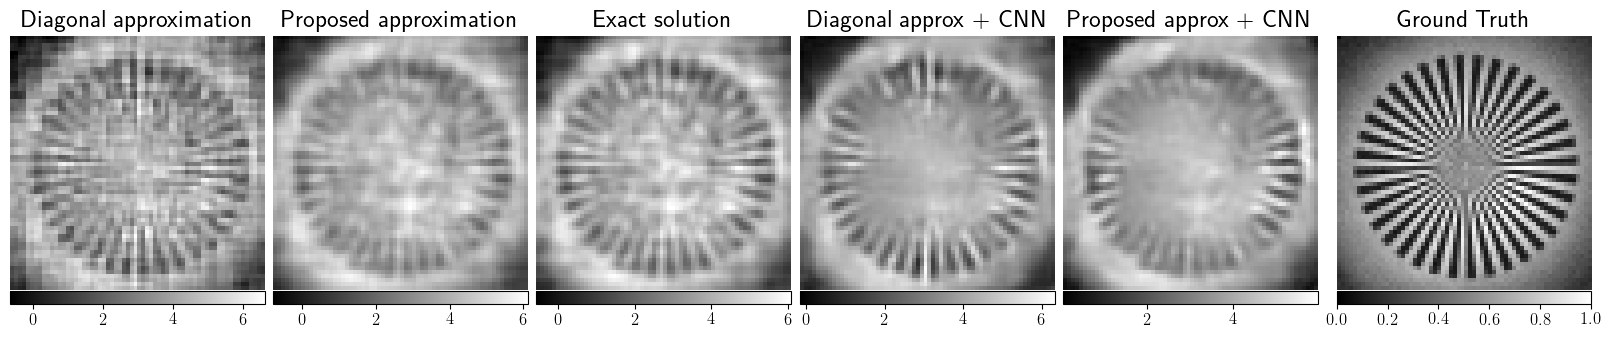

In [44]:
titles = ['Diagonal approximation', 'Proposed approximation', 'Exact solution', 'Diagonal approx + CNN', 'Proposed approx + CNN', 'Ground Truth'] 

print(f'MMSE recon, N0 est = {models[0].N0:.1f}ph (from GT), M = {CR}, Net = {N0}ph, Lambda = {index}')
for i in range(5):
    print (titles[i])
    print("psnr = %.2f" % psnr_(img_GT_all_Channels,img_temp[i]))

fig, axs = plt.subplots(1, 6, figsize=(16, 16), constrained_layout=True)

for i in range(5):
    im = axs[i].imshow(f[i], cmap='gray')
    axs[i].set_title(titles[i], fontsize = 18)
    cbar= plt.colorbar(im, ax=axs[i], shrink=1, orientation = 'horizontal', pad = 0.0)
    cbar.ax.tick_params(labelsize=12)
    axs[i].axis('off')
    
im = axs[5].imshow(img_GT_all_Channels, cmap='gray')
axs[5].set_title(titles[5], fontsize = 18)
cbar=plt.colorbar(im, ax=axs[5], shrink=1, orientation = 'horizontal', pad = 0.0)
cbar.ax.tick_params(labelsize=12)
plt.axis('off')
plt.show

# 6 - Experimental tomato slice

## 6.1 - Loading data and visualising

In [45]:
# f = np.load('./data/tomato_slice/tomato_slice_2_zoomx12_had_reco.npz')
# raw = np.load('./data/tomato_slice/tomato_slice_2_zoomx12_spectraldata.npz')

f = np.load('/home/licho/Documentos/MAS/Stage_Master/Article/Resources/tomato_slice_2_zoomx2_had_reco.npz')
raw = np.load('/home/licho/Documentos/MAS/Stage_Master/Article/Resources/tomato_slice_2_zoomx2_spectraldata.npz')

# for key in f:
#     print(key)

# for key in raw:
#     print(key)    

spectral_data = f['arr_0']
raw_data = raw['spectral_data']

# metadata, acquisition_metadata, spectrometer_parameters, dmd_parameters = read_metadata('./data/zoom_x1_starsector/zoom_x1_metadata.json')
# wavelengths = np.asarray(acquisition_metadata.wavelengths)
# print(f'Spectral data dimensions: {spectral_data.shape}')
# print(f'Wavelength range: {wavelengths[0]} - {wavelengths[-1]} nm')
# print('\nAcquired data description:')
# print(f'Light source: {metadata.light_source}')
# print(f'Object: {metadata.object}')
# print(f'Filter: {metadata.filter}')
# print(f'Patterns: {acquisition_metadata.pattern_amount}')
# print(f'Integration time: {spectrometer_parameters.integration_time_ms} ms')
# print(metadata)


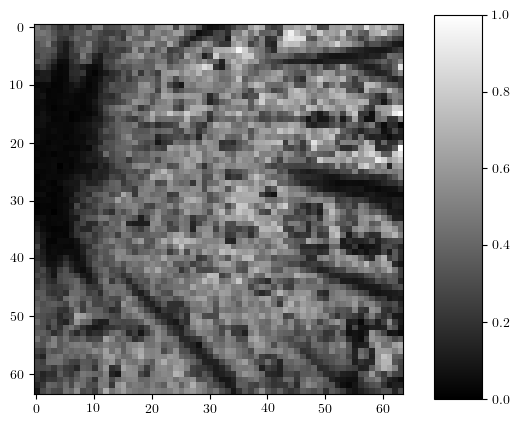

In [46]:
img_GT_all_Channels = np.sum(raw_data, axis = 1)
img_GT_all_Channels = img_GT_all_Channels[0::2] - img_GT_all_Channels[1::2];
img_GT_all_Channels = np.dot(np.transpose(H_k), img_GT_all_Channels);
img_GT_all_Channels = (1/img_size**2)*np.reshape(img_GT_all_Channels, (img_size, img_size))
img_GT_all_Channels = (img_GT_all_Channels-np.amin(img_GT_all_Channels))/(np.amax(img_GT_all_Channels)-np.amin(img_GT_all_Channels))
imagesc(img_GT_all_Channels)

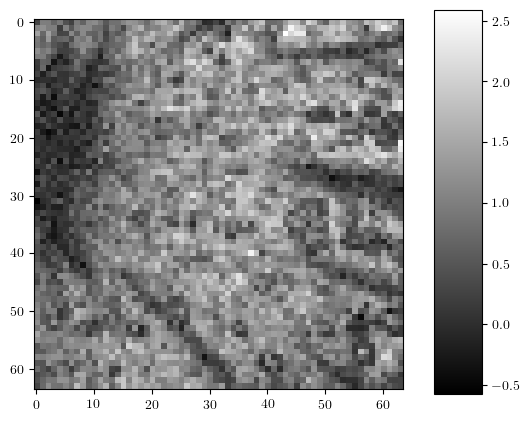

In [47]:
index = 1400
img_GT_index = np.sum(raw_data[:,index-10:index+10], axis = 1)
img_GT_index = img_GT_index[0::2] - img_GT_index[1::2];
img_GT_index = np.dot(np.transpose(H_k), img_GT_index);
img_GT_index = (1/img_size**2)*np.reshape(img_GT_index, (img_size, img_size)) / 20
# img_GT_index = (img_GT_index-np.amin(img_GT_index))/(np.amax(img_GT_index)-np.amin(img_GT_index))
imagesc(img_GT_index)

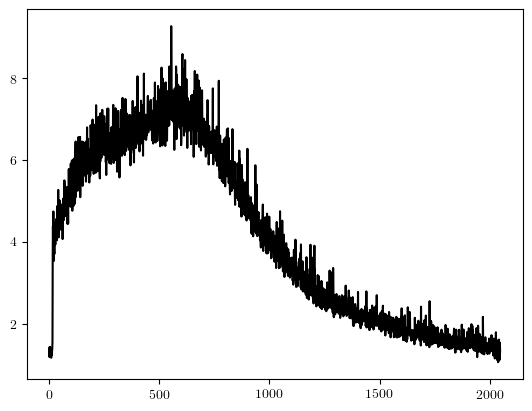

In [48]:
mean_imgs = np.amax(spectral_data, axis = (0,1))
plot(range(mean_imgs.shape[0]),mean_imgs)

In [49]:
index = 1400;
F_bin_GT = spectral_data[:,:,index];
raw_data = raw_data[:,index];
raw_data_spectral = spectral_data[:,:,index-10:index]
# imagesc(F_bin_GT)
img_size = F_bin_GT.shape[0]

In [50]:
m_raw_data = raw_data[:2*CR];

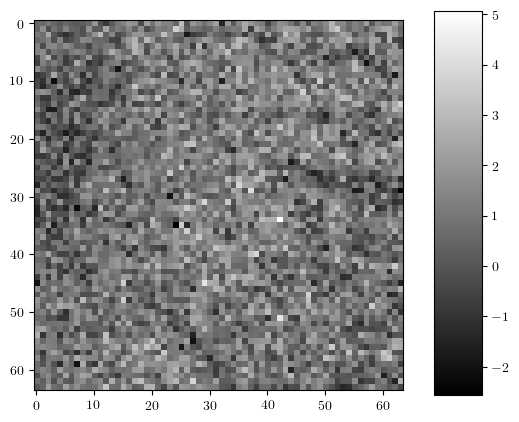

In [51]:
raw_unsplit = raw_data[0::2] - raw_data[1::2];
pinv_test = np.dot(np.transpose(H_k), raw_unsplit);
pinv_test = (1/img_size**2)*np.reshape(pinv_test, (img_size, img_size))
imagesc(pinv_test)

## 6.2 - Pinv reconstruction

In [52]:
m = torch.Tensor(m_raw_data);
m = m.view(1,1,2*CR).to(device);

psnr = 17.8597272589781


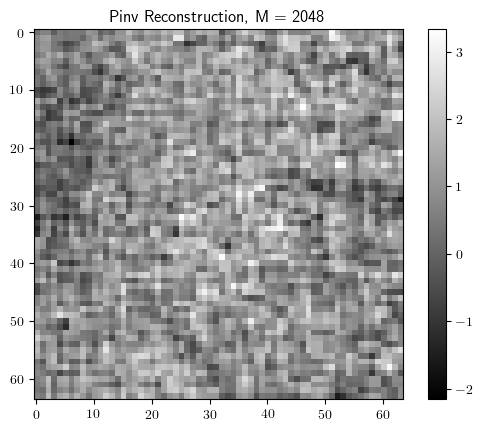

In [53]:
#%% PINV recon
x_inv = models[0].forward_reconstruct_pinv(m, 1, 1, img_size, img_size);
x_inv = (x_inv+1)*models[0].N0/2
recon_pinv = torch2numpy(x_inv.view(img_size,img_size))

plt.figure()
plt.title(f"Pinv Reconstruction, M = {CR}")
plt.imshow(recon_pinv, cmap='gray')
plt.colorbar()

img_temp = recon_pinv;
img_temp = (img_temp -np.amin(img_temp))/(np.amax(img_temp)-np.amin(img_temp))
print("psnr = " + str(psnr_(img_GT_all_Channels,img_temp)))

## 6.3 - MMSE results

In [54]:
# MMSE results
f=[]
img_temp=[]

for i in range(3): # Load analytical layers
    
    models[i].N0 = recon_pinv.max() # setting the maximum light intensity
    
    if i==1:
        NVMS_pinv = np.diag((img_size ** 2) * np.ones(CR)) / recon_pinv.max() # Tuning of the Taylor matrix weights

        P0, P1, P2 = models[i].forward_denoise_operators(Cov, NVMS_pinv, img_size, CR)
        models[i].fcP0 = P0 
        models[i].fcP1 = P1
        models[i].fcP2 = P2
    
    temp = models[i].forward_reconstruct_mmse(m, 1, 1, img_size, img_size)
    temp = (temp + 1) * models[0].N0/2;         
    temp = temp.cpu().detach().numpy().squeeze() 
    f.append(temp)
         
    img_temp.append(f[i])
    img_temp[i] =  (img_temp[i] - np.amin(img_temp[i]))/(np.amax(img_temp[i])-np.amin(img_temp[i]))
    
for i in range(2): # Load CNN layers
    temp = models[i].forward_reconstruct(m, 1, 1, img_size, img_size)
    temp = (temp + 1) * models[0].N0/2;         
    temp = temp.cpu().detach().numpy().squeeze() 
    f.append(temp)
         
    img_temp.append(f[i+3])
    img_temp[i+3] =  (img_temp[i+3] - np.amin(img_temp[i+3]))/(np.amax(img_temp[i+3])-np.amin(img_temp[i+3]))

MMSE recon, N0 est = 3.3ph (from GT), M = 2048, Net = 10ph, Lambda = 1400
Diagonal approximation
psnr = 11.09
Proposed approximation
psnr = 11.03
Exact solution
psnr = 10.90
Diagonal approx + CNN
psnr = 11.05
Proposed approx + CNN
psnr = 11.25


<function matplotlib.pyplot.show(close=None, block=None)>

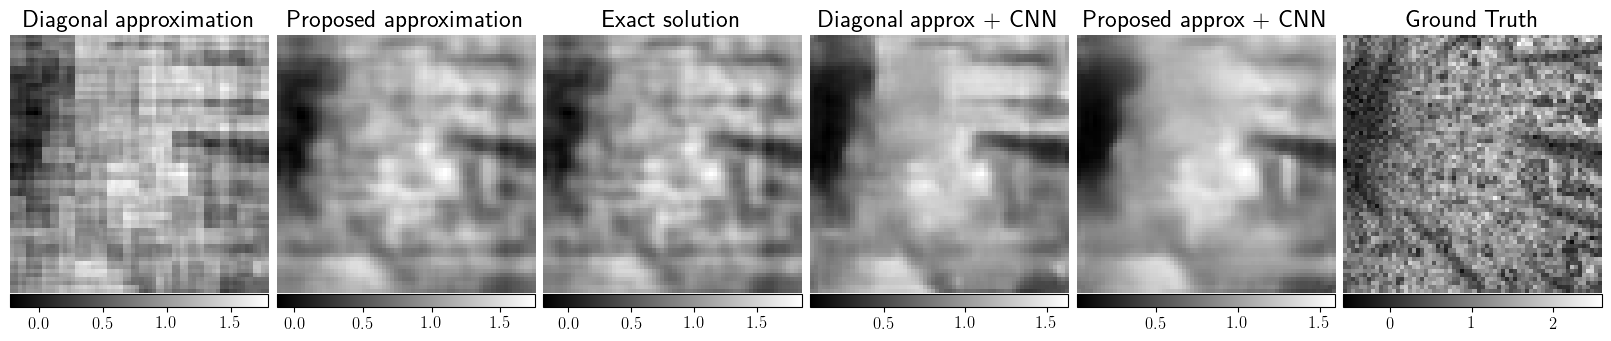

In [56]:
titles = ['Diagonal approximation', 'Proposed approximation', 'Exact solution', 'Diagonal approx + CNN', 'Proposed approx + CNN', 'Ground Truth'] 

print(f'MMSE recon, N0 est = {models[0].N0:.1f}ph (from GT), M = {CR}, Net = {N0}ph, Lambda = {index}')
for i in range(5):
    print (titles[i])
    print("psnr = %.2f" % psnr_(img_GT_index,img_temp[i]))

fig, axs = plt.subplots(1, 6, figsize=(16, 16), constrained_layout=True)

for i in range(5):
    im = axs[i].imshow(f[i], cmap='gray')
    axs[i].set_title(titles[i], fontsize = 18)
    cbar= plt.colorbar(im, ax=axs[i], shrink=1, orientation = 'horizontal', pad = 0.0)
    cbar.ax.tick_params(labelsize=12)
    axs[i].axis('off')
    
im = axs[5].imshow(img_GT_index, cmap='gray')
axs[5].set_title(titles[5], fontsize = 18)
cbar=plt.colorbar(im, ax=axs[5], shrink=1, orientation = 'horizontal', pad = 0.0)
cbar.ax.tick_params(labelsize=12)
plt.axis('off')
plt.show